In [5]:
# Install all needed packages
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install webcolors
%pip install kaggle
%pip install shutils
%pip install Pillow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━

# Machine Learning and Data Mining Project

## Data retrieval
We retrieve all Pokémons data that we need

To run this cell, be sure to have a Kaggle Api Key on your computer in the file `~/.kaggle/kaggle.json`

In [6]:
import kaggle
import os
import shutil

# Si data existe, supprimer le dossier
if os.path.exists('./data'):
    shutil.rmtree('./data')

# Créer le dossier data
os.mkdir('./data')

kaggle.api.authenticate()

kaggle.api.dataset_download_files('kvpratama/pokemon-images-dataset', path='./data/', unzip=True)
kaggle.api.dataset_download_files('vishalsubbiah/pokemon-images-and-types', path='./data/', unzip=True)

# Supprimer le dossier ./data/pokemon_jpg et ./data/images
shutil.rmtree('./data/pokemon_jpg')
shutil.rmtree('./data/images')

# Move ./data/pokemon/pokemon dans ./data/pokemon_images
shutil.move('./data/pokemon/pokemon/', './data/pokemon_images')

# Supprimer le dossier ./data/pokemon
shutil.rmtree('./data/pokemon')

# Remove every file that does not have only number
for file in os.listdir('./data/pokemon_images'):
    if not file.split('.')[0].isdigit():
        os.remove('./data/pokemon_images/' + file)

for file in os.listdir('./data/pokemon_images/'):
    # Remove every file that has a name over 151
    if int(file.split('.')[0]) > 151:
        os.remove('./data/pokemon_images/' + file)

# Ajouter les id des pokémons dans le fichier data/pokemon.csv
"""
Name,Type1,Type2
bulbasaur,Grass,Poison
ivysaur,Grass,Poison
venusaur,Grass,Poison
charmander,Fire

=>
Id,Name,Type1,Type2
1,bulbasaur,Grass,Poison
2,ivysaur,Grass,Poison
3,venusaur,Grass,Poison
4,charmander,Fire
"""

file = open('./data/pokemon.csv', 'r')
lines = file.readlines()
file.close()

file = open('./data/pokemon.csv', 'w')
file.write('Id,Name,Type1,Type2\n')
for i in range(1, len(lines)):
    file.write(str(i) + ',' + lines[i])
file.close()


In [7]:
# Création des méta-données de chaque pokémon
"""
{
    "path": filename,
    "size" : imgfile.size,
    "format" : extension,
    "orientation" : orientation
}
"""

# Loop through every image (png file) and gather path, size, format, orientation, and write everything to a json file
import json
import os
import shutil
from PIL import Image

# Create a folder for the json files
if os.path.exists('./data/json_metadata_files'):
    shutil.rmtree('./data/json_metadata_files')
os.makedirs('./data/json_metadata_files', exist_ok=True)

# Create a list of all the files in the directory
png_files = os.listdir('./data/pokemon_images')

# sort the list in numerical order (file name : 100.png => 100)
png_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
print(png_files)

for file in png_files :
    imgfile = Image.open('./data/pokemon_images/' + file)

    # Get the size :
    width, height = imgfile.size

    # Get the extension :
    extension = file.split('.')[-1]

    # Get the orientation :
    orientation = 'landscape' if width > height else 'portrait'

    # Create a dictionary with the data
    data = {
        "path": file,
        "size" : imgfile.size,
        "format" : extension,
        "orientation" : orientation
    }

    print(f"Image : {file} | Size : {imgfile.size} | Format : {extension} | Orientation : {orientation}")

    # Write the data to a json file
    json_file = open('./data/json_metadata_files/' + file.split('.')[0] + '.json', 'w')
    json.dump(data, json_file)
    json_file.close()


['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png', '101.pn

# Data categorization

## Discrimation criterias

* Type1/Type2
* Color

Tag : #color, #type

In [8]:
import os
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from PIL import Image

colors_dict = {}

# Fonction pour obtenir les couleurs dominantes d'une image
def get_dominant_colors(image_path, k, image_processing_size=None):
    # Charger l'image et la convertir en tableau numpy
    image = Image.open(image_path)

    # Redimensionner l'image pour accélérer le traitement
    if image_processing_size is not None:
        image = image.resize(image_processing_size, Image.Resampling.LANCZOS)

    # Convertir l'image en tableau numpy
    image = np.array(image)

    # Transformer le tableau numpy en un tableau 2D
    w, h, d = tuple(image.shape)
    image_array = np.reshape(image, (w * h, d))

    # Appliquer l'algorithme K-Means
    # kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(image_array)
    # Use mini-batch k-means instead
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=256, n_init=10).fit(image_array)

    # Obtenir les couleurs dominantes
    dominant_colors = []
    for center in kmeans.cluster_centers_:
        # All files are png, so we have to ignore very low alpha values
        if center[3] < 10:
            continue
        dominant_colors.append(center)

    try :
        colors = [
            [
                dominant_colors[0][0],
                dominant_colors[0][1],
                dominant_colors[0][2]
            ],
            [
                dominant_colors[1][0],
                dominant_colors[1][1],
                dominant_colors[1][2]
            ],
            [
                dominant_colors[2][0],
                dominant_colors[2][1],
                dominant_colors[2][2],
            ]
        ]
    except :
        colors = [
            [
                dominant_colors[0][0],
                dominant_colors[0][1],
                dominant_colors[0][2]
            ],
            [
                dominant_colors[1][0],
                dominant_colors[1][1],
                dominant_colors[1][2]
            ]
        ]

    return colors


# Parcourir tous les fichiers d'images dans le dossier
images_folder = "./data/pokemon_images"
cpt = 0

png_files = os.listdir(images_folder)
# sort the list in numerical order (file name : 100.png => 100)
png_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

for filename in png_files:
    image_path = os.path.join(images_folder, filename)

    # Obtenir les couleurs 3 dominantes de l'image
    colors = get_dominant_colors(image_path, 5, (100, 100))

    # Print the progress
    cpt+=1
    print(str(cpt) + "/" + str(len(os.listdir(images_folder))))
    print(image_path)

    # Add the colors to the colors_dict dictionary
    colors_dict[filename] = colors



1/151
./data/pokemon_images/1.png
2/151
./data/pokemon_images/2.png
3/151
./data/pokemon_images/3.png
4/151
./data/pokemon_images/4.png
5/151
./data/pokemon_images/5.png
6/151
./data/pokemon_images/6.png
7/151
./data/pokemon_images/7.png
8/151
./data/pokemon_images/8.png
9/151
./data/pokemon_images/9.png
10/151
./data/pokemon_images/10.png
11/151
./data/pokemon_images/11.png
12/151
./data/pokemon_images/12.png
13/151
./data/pokemon_images/13.png
14/151
./data/pokemon_images/14.png
15/151
./data/pokemon_images/15.png
16/151
./data/pokemon_images/16.png
17/151
./data/pokemon_images/17.png
18/151
./data/pokemon_images/18.png
19/151
./data/pokemon_images/19.png
20/151
./data/pokemon_images/20.png
21/151
./data/pokemon_images/21.png
22/151
./data/pokemon_images/22.png
23/151
./data/pokemon_images/23.png
24/151
./data/pokemon_images/24.png
25/151
./data/pokemon_images/25.png
26/151
./data/pokemon_images/26.png
27/151
./data/pokemon_images/27.png
28/151
./data/pokemon_images/28.png
29/151
./d

In [9]:
# Convert it to json format
j = str(colors_dict).replace("'", '"')

# j to json :
json_file = open('./data/colors.json', 'w')
json_file.write(j)
json_file.close()

## Data gathering in a single file

In [10]:
# Fichier csv : data/pokemon.csv
"""
Id,Name,Type1,Type2
1,bulbasaur,Grass,Poison
2,ivysaur,Grass,Poison
"""

# Fichiers json des méta-données : data/json_metadata_files
"""
{
    "path": "1.png",
    "size" : [256, 256],
    "format" : "png",
    "orientation" : "portrait"
}
"""

# Fichier JSON des couleurs dominantes : data/colors.json
"""
{
    "1.png": [
        [117, 165, 142],
        [5, 10, 7],
        [160, 207, 189]
    ],
}
"""

import os
import json
import webcolors
from scipy.spatial import KDTree

def find_closest_color(requested_color, color_list):
    """Find the closest color to a given RGB value"""
    # Create a KDTree from the list of colors
    tree = KDTree(color_list)
    # Query the tree for the nearest color
    dist, index = tree.query(requested_color)
    return color_list[index]

def get_metadata(id, file_list):
    file = open('./data/json_metadata_files/' + file_list[int(id)-1], 'r')
    metadata = file.read()
    file.close()

    metadata = json.loads(metadata)

    return metadata

def get_colors(id, colors_dict):

    color_list = []
    for color in webcolors.CSS3_HEX_TO_NAMES.keys():
        color_list.append(webcolors.hex_to_rgb(color))

    colors = colors_dict[f"{id}.png"]
    color_names = []
    for color in colors:
        closest_color = find_closest_color(color, color_list)
        color_name = webcolors.rgb_to_name(closest_color)
        color_names.append(color_name)
    return color_names


# Création d'un dict data pour le fichier data.json
data = {}

# Récupération des données du fichier data/pokemon.csv
file = open('./data/pokemon.csv', 'r')
lines_pokemon_csv = file.readlines()
file.close()

lines_pokemon_csv = lines_pokemon_csv[1:]
lines_pokemon_csv = [line.replace("\n", "").split(',') for line in lines_pokemon_csv]

# Récupération des données du fichier data/json_metadata_files
list_metadata_files = os.listdir('./data/json_metadata_files')
# sort the list in numerical order (file name : 100.png => 100)
list_metadata_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# Récupération des données du fichier data/colors.json
file = open('./data/colors.json', 'r')
colors_json = file.read()
file.close()

colors_json = json.loads(colors_json)

# Remplissage du dict data
for line in lines_pokemon_csv :
    if int(line[0]) > 151 :
        break
    print(line)
    # check if there is more than one type
    if len(line) > 3:
        pokemon = {
            "id": line[0],
            "name": line[1],
            "type1": line[2],
            "type2": line[3],
            "metadata": get_metadata(line[0], list_metadata_files),
            "colors": get_colors(line[0], colors_json)
        }
    else :
        pokemon = {
            "id": line[0],
            "name": line[1],
            "type1": line[2],
            "metadata": get_metadata(line[0], list_metadata_files),
            "colors": get_colors(line[0], colors_json)
        }

    data[line[0]] = pokemon

# Convert it to json format
j = str(data).replace("'", '"')

# j to json :
json_file = open('./data/data.json', 'w')
json_file.write(j)
json_file.close()

['1', 'bulbasaur', 'Grass', 'Poison']
['2', 'ivysaur', 'Grass', 'Poison']
['3', 'venusaur', 'Grass', 'Poison']
['4', 'charmander', 'Fire']
['5', 'charmeleon', 'Fire']
['6', 'charizard', 'Fire', 'Flying']
['7', 'squirtle', 'Water']
['8', 'wartortle', 'Water']
['9', 'blastoise', 'Water']
['10', 'caterpie', 'Bug']
['11', 'metapod', 'Bug']
['12', 'butterfree', 'Bug', 'Flying']
['13', 'weedle', 'Bug', 'Poison']
['14', 'kakuna', 'Bug', 'Poison']
['15', 'beedrill', 'Bug', 'Poison']
['16', 'pidgey', 'Normal', 'Flying']
['17', 'pidgeotto', 'Normal', 'Flying']
['18', 'pidgeot', 'Normal', 'Flying']
['19', 'rattata', 'Normal']
['20', 'raticate', 'Normal']
['21', 'spearow', 'Normal', 'Flying']
['22', 'fearow', 'Normal', 'Flying']
['23', 'ekans', 'Poison']
['24', 'arbok', 'Poison']
['25', 'pikachu', 'Electric']
['26', 'raichu', 'Electric']
['27', 'sandshrew', 'Ground']
['28', 'sandslash', 'Ground']
['29', 'nidoran-f', 'Poison']
['30', 'nidorina', 'Poison']
['31', 'nidoqueen', 'Poison', 'Ground']
['3

## User Profiles

In [40]:
import random

# Création des profil d'utilisateurs, élements favoris: type, couleurs.
class User:
    def __init__(self, id, name, images_list):
        self.id = id
        self.name = name
        self.images_list = images_list
        self.favorite_types = []
        self.favorite_colors = []
        self.liked_images = []
        self.recommended_images = []

    def add_favorite_type(self, type):
        self.favorite_types.append(type)

    def add_favorite_color(self, color):
        self.favorite_colors.append(color)

    def get_favorite_types(self):
        return self.favorite_types

    def get_favorite_colors(self):
        return self.favorite_colors

    def get_images_list(self):
        return self.images_list

    def get_liked_images(self):
        return self.liked_images

    def print_user(self):
        print(f"User {self.id} : {self.name}")
        print(f"Favorite types : {self.favorite_types}")
        print(f"Favorite colors : {self.favorite_colors}")
        print(f"Images list : {self.images_list}")
        print(f"Liked images : {self.liked_images}")

    def get_data(self):
        return {
            "id": self.id,
            "name": self.name,
            "favorite_types": self.favorite_types,
            "favorite_colors": self.favorite_colors,
            "images_list": self.images_list,
            "liked_images": self.liked_images,
            "recommended_images": self.recommended_images
        }


# All types :
types = ["Normal", "Fire", "Water", "Electric", "Grass", "Ice", "Fighting", "Poison", "Ground", "Flying", "Psychic", "Bug", "Rock", "Ghost", "Dragon", "Dark", "Steel", "Fairy"]

NOMBRE_UTILISATEURS = 5
NOMBRE_IMAGES = 10

# Création des utilisateurs
users = []
for i in range(NOMBRE_UTILISATEURS):
    # Création d'une liste d'images aléatoire
    images_list = []
    for j in range(NOMBRE_IMAGES):
        images_list.append(random.randint(1, 151))
    users.append(User(i, f"user{i}", images_list))




In [41]:
"""
One piece of the data.json file
{
    "1": {
        "id": "1",
        "name": "bulbasaur",
        "type1": "Grass",
        "type2": "Poison",
        "metadata": {
            "path": "1.png",
            "size": [
                256,
                256
            ],
            "format": "png",
            "orientation": "portrait"
        },
        "colors": [
            "dimgray",
            "cadetblue",
            "silver"
        ]
    },
}
"""

# Like random des images pour chaque utilisateur

import random
import webcolors
from scipy.spatial import KDTree

# On vide les données des utilisateurs
for user in users:
    user.favorite_types = []
    user.favorite_colors = []
    user.liked_images = []


for user in users:
    for image in user.get_images_list():
        user.liked_images.append((image, True if random.randint(0, 1) == 1 else False))

# Ajout de types et de couleurs favoris pour chaque utilisateur en fonction des images likées, et ajout du nombre de fois que le type ou la couleur est liké
for user in users:
    for image_like_relation in user.get_liked_images():
        # Si l'image est likée
        if image_like_relation[1]:
            # Récupération des données de l'image
            file = open('./data/data.json', 'r')
            data = file.read()
            file.close()

            data = json.loads(data)

            image_data = data[str(image_like_relation[0])]

            # Ajout des types favoris
            if "type2" in image_data:
                user.add_favorite_type(image_data["type1"])
                user.add_favorite_type(image_data["type2"])
            else:
                user.add_favorite_type(image_data["type1"])

            # Ajout des couleurs favoris
            for color in image_data["colors"]:
                user.add_favorite_color(color)


# Compter le nombre d'occurence de chaque type et de chaque couleur
for user in users:
    # Types
    user.favorite_types = {i: user.favorite_types.count(i) for i in user.favorite_types}
    # Couleurs
    user.favorite_colors = {i: user.favorite_colors.count(i) for i in user.favorite_colors}

# Trie dans l'ordre décroissant
for user in users:
    # Types
    user.favorite_types = dict(sorted(user.favorite_types.items(), key=lambda item: item[1], reverse=True))
    # Couleurs
    user.favorite_colors = dict(sorted(user.favorite_colors.items(), key=lambda item: item[1], reverse=True))


In [42]:
for user in users:
    print("=====================================")
    user.print_user()

User 0 : user0
Favorite types : {'Psychic': 2, 'Ice': 1, 'Flying': 1, 'Grass': 1, 'Normal': 1, 'Electric': 1, 'Steel': 1, 'Dragon': 1}
Favorite colors : {'darkslategray': 3, 'dimgray': 2, 'darkgray': 2, 'slategray': 1, 'lightsteelblue': 1, 'mistyrose': 1, 'silver': 1, 'peru': 1, 'wheat': 1, 'whitesmoke': 1, 'gainsboro': 1, 'sandybrown': 1, 'darkolivegreen': 1, 'lightgray': 1}
Images list : [102, 144, 102, 133, 81, 119, 147, 97, 86, 42]
Liked images : [(102, False), (144, True), (102, True), (133, True), (81, True), (119, False), (147, True), (97, True), (86, False), (42, False)]
User 1 : user1
Favorite types : {'Normal': 2, 'Fighting': 2, 'Grass': 1, 'Poison': 1, 'Psychic': 1, 'Flying': 1}
Favorite colors : {'rosybrown': 3, 'dimgray': 2, 'darkolivegreen': 2, 'sienna': 1, 'wheat': 1, 'darkgray': 1, 'lightsteelblue': 1, 'antiquewhite': 1, 'cadetblue': 1, 'darkslategray': 1, 'peru': 1, 'khaki': 1, 'tan': 1, 'gray': 1}
Images list : [20, 66, 57, 24, 3, 43, 64, 33, 77, 17]
Liked images : [(

In [43]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist

NOMBRE_RECOMMANDATIONS = 3

def load_data(json_file):
    with open(json_file, "r") as file:
        data = json.load(file)
    return data

data = load_data("data/data.json")

def extract_features(data):
    features = []
    for id, pokemon in data.items():
        img = Image.open(os.path.join("data/pokemon_images", pokemon["metadata"]["path"]))
        img = img.resize((64, 64))
        img_array = np.asarray(img)
        img_array = img_array.flatten() / 255.0
        features.append(img_array)
    return np.array(features)

features = extract_features(data)

n_clusters = 10
minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, n_init=10)
minibatch_kmeans.fit(features)

def find_closest_cluster(user, data, minibatch_kmeans):
    user_preferences = []

    for id, pokemon in data.items():
        type1 = pokemon.get("type1", "")
        type2 = pokemon.get("type2", "")
        if type1 in user.get_favorite_types() or type2 in user.get_favorite_types():
            for color in pokemon["colors"]:
                if color in user.get_favorite_colors():
                    user_preferences.append((id, pokemon))
                    break

    user_features = extract_features({id: pokemon for id, pokemon in user_preferences})
    cluster_assignments = minibatch_kmeans.predict(user_features)

    closest_cluster = np.argmax(np.bincount(cluster_assignments))
    return closest_cluster

def recommend_images(data, minibatch_kmeans, closest_cluster, user_features, max_recommendations, liked_images_ids):
    distances = []

    for id, pokemon in data.items():
        img_features = extract_features({id: pokemon}).reshape(1, -1)
        cluster_assignment = minibatch_kmeans.predict(img_features)

        if cluster_assignment == closest_cluster and id not in liked_images_ids:
            distance = np.linalg.norm(user_features - img_features)
            distances.append((id, distance))

    # Triez les images en fonction de leur distance par rapport aux préférences de l'utilisateur
    sorted_distances = sorted(distances, key=lambda x: x[1])

    # Prenez les max_recommendations images les plus proches
    closest_images_ids = [x[0] for x in sorted_distances[:max_recommendations]]

    return closest_images_ids



recommendations = {}

for user in users:
    closest_cluster = find_closest_cluster(user, data, minibatch_kmeans)
    user_features = extract_features({str(id): data[str(id)] for id, liked in user.get_liked_images() if liked})
    liked_images_ids = [str(id) for id, liked in user.get_liked_images() if liked]
    recommendations[user.name] = recommend_images(data, minibatch_kmeans, closest_cluster, user_features, NOMBRE_RECOMMANDATIONS, liked_images_ids)

print(recommendations)


for user_name, recommended_pokemons in recommendations.items():
    print(f"{user_name} a {len(recommended_pokemons)} Pokémon recommandés : {recommended_pokemons}")

# Ajout des recommandations dans les données des utilisateurs
for user in users:
    user.recommended_images = recommendations[user.name]


{'user0': ['3', '93', '44'], 'user1': ['44', '83', '88'], 'user2': ['93', '88', '3'], 'user3': ['51', '50', '111'], 'user4': ['111', '50', '32']}
user0 a 3 Pokémon recommandés : ['3', '93', '44']
user1 a 3 Pokémon recommandés : ['44', '83', '88']
user2 a 3 Pokémon recommandés : ['93', '88', '3']
user3 a 3 Pokémon recommandés : ['51', '50', '111']
user4 a 3 Pokémon recommandés : ['111', '50', '32']


## Data saving

In [44]:
import json

# Ecriture des données de tous les utilisateurs dans un fichier "data/users.json"
with open("data/users.json", "w") as file:
    json.dump([user.__dict__ for user in users], file)


## Final Data Visualization

/tmp/ipykernel_332/2454410751.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(gs[0, i])
/tmp/ipykernel_332/2454410751.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(gs[1, i])


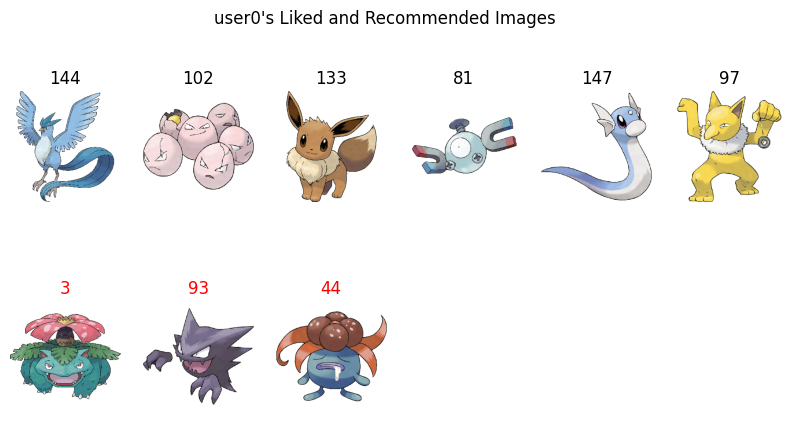

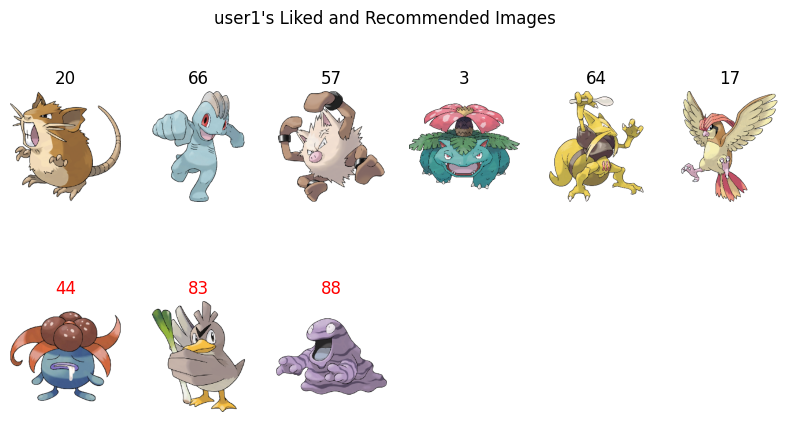

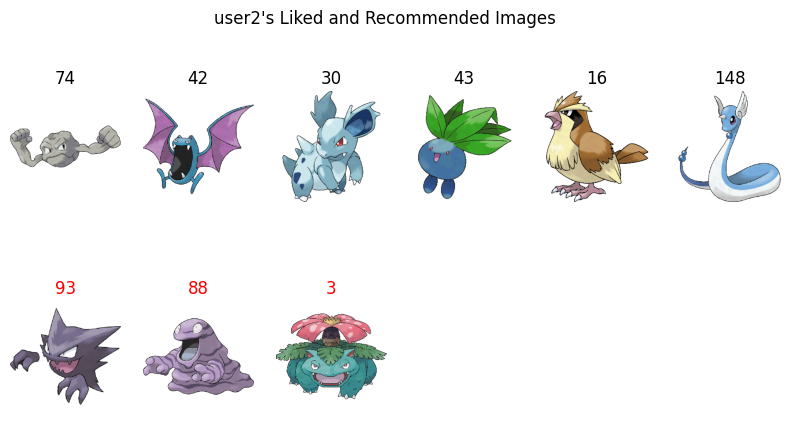

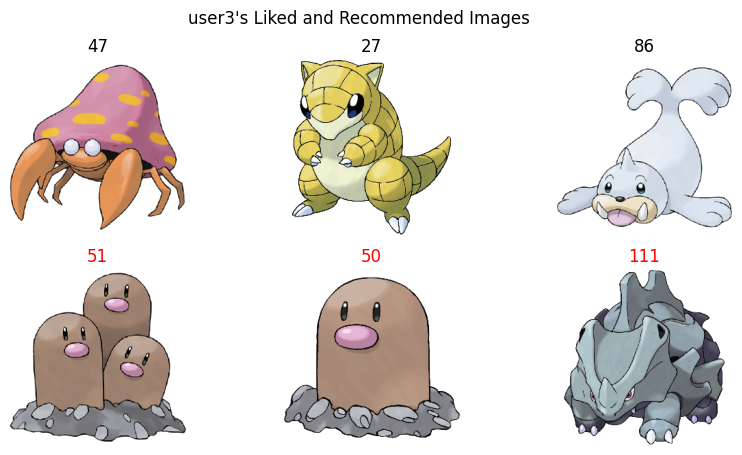

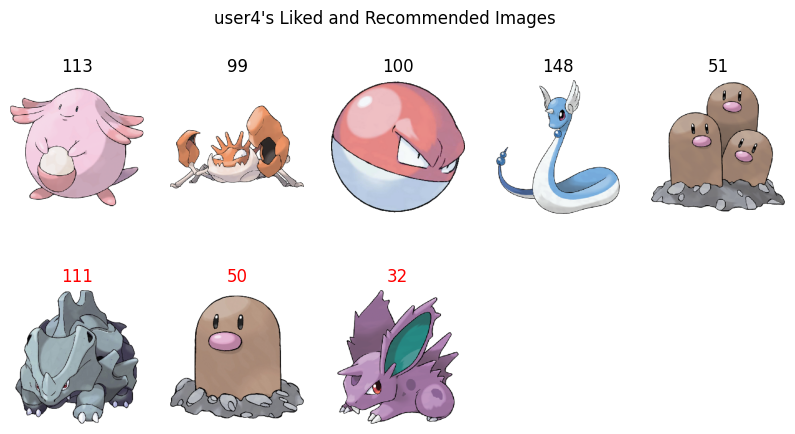

In [45]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_images(user_name, liked_images, recommended_images):
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(2, len(liked_images), figure=fig)

    # Affichez les images aimées
    plt.subplot(gs[0, :])
    for i, image_id in enumerate(liked_images):
        img = Image.open(os.path.join("data/pokemon_images", data[image_id]["metadata"]["path"]))
        plt.subplot(gs[0, i])
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{image_id}")

    # Affichez les images recommandées
    plt.subplot(gs[1, :])
    for i, image_id in enumerate(recommended_images):
        img = Image.open(os.path.join("data/pokemon_images", data[image_id]["metadata"]["path"]))
        plt.subplot(gs[1, i])
        plt.imshow(img)
        plt.axis("off")
        # Make this title RED
        plt.title(f"{image_id}", color="red")

    plt.suptitle(f"{user_name}'s Liked and Recommended Images")
    plt.show()

# Créez un dictionnaire pour stocker les utilisateurs avec leur nom comme clé
users_dict = {user.name: user for user in users}

# Affichez les images aimées et recommandées pour chaque utilisateur
for user_name, recommended_images in recommendations.items():
    user = users_dict[user_name]
    liked_images = [str(id) for id, liked in user.get_liked_images() if liked]
    plot_images(user_name, liked_images, recommended_images)


